<a href="https://colab.research.google.com/github/Ralph-arch4/sentiment_analysis_with_bert/blob/main/Chronic_Kidney_Disease_ML_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chronic Kidney Disease
Il dataset analizzato riguarda la diagnosi precoce della **Malattia Renale Cronica (Chronic Kidney Disease – CKD)**. Proviene dall’UCI Machine Learning Repository ed è stato raccolto da medici nefrologi indiani. Contiene **400 osservazioni** e **24 attributi clinici**, più una colonna `class` che indica la presenza (`ckd`) o l’assenza (`notckd`) della malattia. Le variabili includono valori numerici (età, pressione, creatinina, potassio, ecc.) e categoriali (presenza di batteri, cellule anomale, diabete, ecc.). La classe è sbilanciata: 250 pazienti affetti da CKD e 150 non affetti. Come spesso accade in ambito medico, diversi attributi presentano valori mancanti, che dovranno essere gestiti opportunamente durante il preprocessing. L’obiettivo è identificare precocemente la malattia attraverso modelli di apprendimento automatico, valutando anche la qualità delle variabili e la loro importanza nella classificazione.

Innanzitutto carichiamo il dataset CKD e visualizziamo l'anteprima:

In [3]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

ckd = fetch_ucirepo(id=336)
X = ckd.data.features
y = ckd.data.targets
df = pd.concat([X, y], axis=1)

print("Forma del dataset:", df.shape)
df.head()


Forma del dataset: (400, 25)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


la fase successiva consiste nel preprocessing dei dati, che è fondamentale per garantire la qualità dell’analisi e il buon funzionamento dei modelli supervisionato, non supervisionato e semi-supervisionato.

### Controllo e gestione dei valori mancanti:
Controlliamo i cosiddetti missing values, i valori Nan e i simboli anomali e li convertiamo correttamente.

In [4]:
df.replace('?', pd.NA, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')  # converte le colonne numeriche
df = df.dropna()  # oppure df.fillna(method='ffill') per imputazione


<ipython-input-4-3526735599>:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')  # converte le colonne numeriche


### Encoding delle variabili categoriche :
Usiamo One-Hot Encoding per variabili nominali e Label Encoding se appropriato per le ordinali.

In [5]:
from sklearn.preprocessing import LabelEncoder

# Codifica le variabili categoriche (esempio con LabelEncoder)
label_enc = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_enc.fit_transform(df[col])


### Normalizzazione o Standardizzazione dei dati:
Consigliata per la maggior parte degli algoritmi ML(KMeans, SVM, ecc.).

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['class']))  # supponendo che 'class' sia il target
y = df['class']


Tentiamo un ultima analisi esplorativa che identifichi visivamente le relazioni tra le feature e il target :

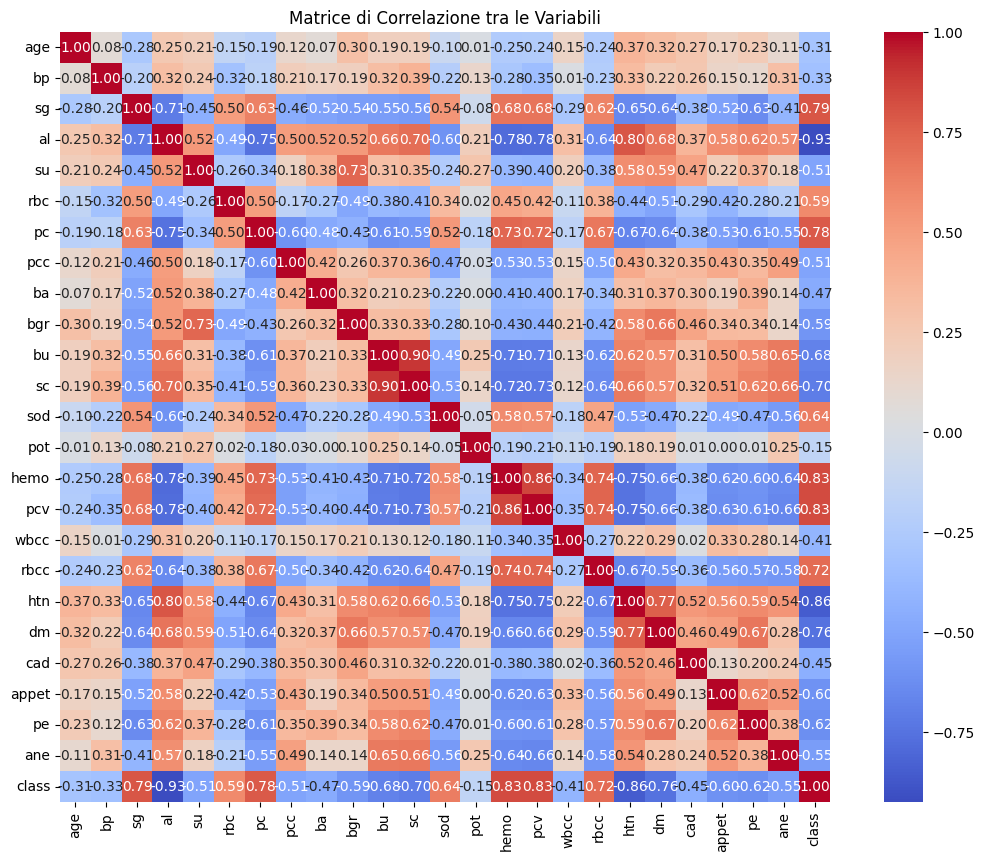

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di correlazione
corr = df.corr()

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matrice di Correlazione tra le Variabili")
plt.show()


Il grafico mostra chiaramente che alcune variabili sono fortemente correlate con la variabile target class, indicando che sono potenzialmente predittive della presenza o assenza di malattia renale cronica (CKD). Altre variabili risultano invece debolmente correlate, suggerendo scarsa utilità informativa.

*   **hemo, pcv, rbcc**: positivamente correlate → valori più alti sono associati alla classe "non malato".

* **al, sg, bu, sc**: negativamente correlate → valori più alti sono tipici della classe "malato".


Queste variabili biologiche riflettono indicatori clinici diretti dello stato renale, quindi sono fondamentali da mantenere nel modello predittivo.


Variabili come bp, sod, pot, age, pe, appet mostrano bassa o quasi nulla correlazione con class.

Queste feature potrebbero non contribuire significativamente alla predizione della malattia, e si può considerare di escluderle o ridurne l’importanza nei modelli.

In [9]:
#"Puliamo i dati" come ci suggerisce la matrice di correlazione


# 1. Copia del DataFrame originale (df già esistente e pulito)
df_cleaned = df.copy()

# 2. Rimuovi feature debolmente correlate con la variabile target (threshold arbitrario: |corr| < 0.2)
low_corr_features = ['bp', 'sod', 'pot', 'age', 'pe', 'appet']
df_cleaned.drop(columns=low_corr_features, inplace=True)

# 3. Rimuovi feature altamente collineari tra loro (basato su osservazione del grafico)
# hemo vs pcv: tiene hemo, rimuove pcv
# bu vs sc: tiene bu, rimuove sc
# rbcc vs pcv: già rimosso pcv, quindi ok

highly_collinear_to_drop = ['pcv', 'sc']
df_cleaned.drop(columns=highly_collinear_to_drop, inplace=True)

# 4. Verifica finale
print("Shape finale del dataset:", df_cleaned.shape)
print("Colonne finali:\n", df_cleaned.columns)

# Il DataFrame è ora pronto per il supervised learning
X = df_cleaned.drop(columns='class')  # Features
y = df_cleaned['class']               # Target



Shape finale del dataset: (158, 17)
Colonne finali:
 Index(['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'hemo', 'wbcc',
       'rbcc', 'htn', 'dm', 'cad', 'ane', 'class'],
      dtype='object')


## Abbiamo :

*   Rimosso rumore e ridondanza.
*   Il dataset è più piccolo ma più denso di informazioni di "qualità" pronto per il modello supervisionato.



## Apprendimento Supervisionato
L’apprendimento supervisionato è una categoria di algoritmi di machine learning in cui un modello impara a prevedere un output (etichetta) a partire da dati di input etichettati.

Nel nostro caso, il modello impara a classificare i pazienti come affetti o meno da malattia renale cronica (CKD), partendo da parametri clinici come hemo, sg, al, ecc.

I modelli supervisionati che scegliamo sono:  
### Logistic Regression

La regressione logistica è uno degli algoritmi più semplici e interpretabili utilizzati per problemi di classificazione, in particolare binaria. Nonostante il nome, non si tratta di un algoritmo di regressione in senso stretto, ma di un metodo che, dato un insieme di variabili indipendenti, stima la probabilità che l’osservazione appartenga a una determinata classe.

L’idea centrale è quella di trasformare una combinazione lineare delle feature in una probabilità grazie alla funzione sigmoide, che restituisce valori compresi tra 0 e 1. In pratica, il modello costruisce una frontiera decisionale lineare nello spazio delle caratteristiche, separando le classi. Quando i dati sono ben separabili in modo lineare, la regressione logistica può funzionare molto bene, fornendo anche informazioni utili sull’importanza relativa delle variabili.

Tuttavia, nei casi in cui i dati presentano relazioni più complesse, non lineari, la regressione logistica può risultare troppo semplice, portando a risultati poco soddisfacenti. In quei casi, modelli più sofisticati possono essere preferiti. Resta comunque molto apprezzata per la sua rapidità, efficienza e trasparenza, ed è spesso usata come punto di partenza per valutare la complessità del problema.


### Random Forest

La Random Forest è un algoritmo di classificazione basato su una collezione di alberi decisionali. L’idea è semplice ma geniale: costruire molti alberi, ognuno addestrato su un campione casuale (con reinserimento) dei dati originali, e poi fare in modo che “votino” per la classe più probabile. Questo processo prende il nome di bagging (bootstrap aggregating) e serve a ridurre l’overfitting, uno dei limiti tipici degli alberi decisionali singoli.

Ciò che rende la Random Forest così efficace è la combinazione di varianza ridotta (grazie alla media delle previsioni di molti alberi) e robustezza rispetto ai dati rumorosi o con outlier. Inoltre, il modello è in grado di gestire in modo naturale sia variabili numeriche che categoriche, e fornisce anche una stima dell’importanza di ciascuna variabile, utile per l’interpretazione del modello.

Nonostante la sua complessità interna, la Random Forest è relativamente facile da usare: funziona bene senza un’eccessiva taratura dei parametri, e si adatta a molti contesti pratici. Tuttavia, il prezzo da pagare è la perdita di interpretabilità: mentre un albero decisionale singolo può essere facilmente letto e interpretato, una foresta composta da centinaia di alberi no.

### Support Vector Classifier(SVC)

La Support Vector Machine è un algoritmo più potente e teoricamente sofisticato rispetto alla regressione logistica. Anche la SVM cerca una frontiera decisionale che separi le classi, ma con una strategia diversa: invece di cercare semplicemente una linea qualsiasi che separa i dati, la SVM costruisce l’iperpiano ottimale, ovvero quello che massimizza la distanza (il margine) tra le due classi.

Questa caratteristica rende la SVM particolarmente efficace nei problemi in cui le classi sono separabili solo con una certa complessità. Inoltre, grazie all’utilizzo dei kernel, la SVM può mappare i dati in spazi dimensionalmente più elevati, riuscendo a separare anche classi che non sono linearmente separabili nello spazio originale.

L’algoritmo è noto per le sue ottime prestazioni soprattutto in presenza di dataset di dimensioni medie e con un numero elevato di feature. Tuttavia, può essere più lento da addestrare rispetto ad altri modelli, e meno interpretabile, soprattutto quando si utilizzano kernel complessi. Resta comunque una delle scelte migliori quando si cerca un equilibrio tra accuratezza e controllo del modello.





📌 Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        23

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32


📌 Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        23

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32


📌 SVM:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        23

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.

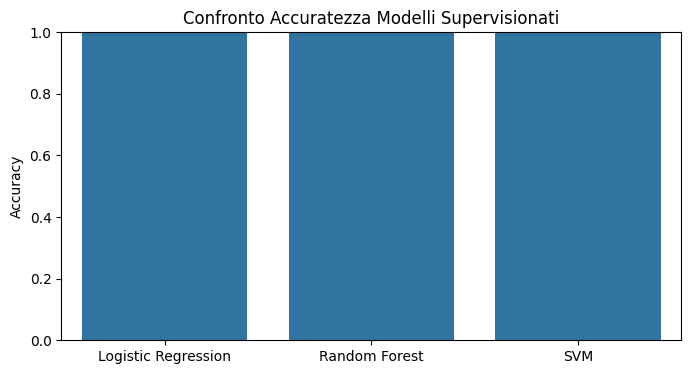

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Suddivisione in train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Standardizzazione (importante per SVM e LR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Modelli da testare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC()
}

# 4. Addestramento e valutazione
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n📌 {name}:\n")
    print(classification_report(y_test, y_pred, zero_division=0))
    results[name] = acc

# 5. Grafico comparativo delle accuracy
plt.figure(figsize=(8, 4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Confronto Accuratezza Modelli Supervisionati")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


Abbiamo testato la validità di questi modelli di apprendimento attraverso diverse metriche:

* ### Accuracy:
Percentuale di previsioni corrette sul totale,è utile quando le classi sono bilanciate.

* ### Precision:
Quanti dei casi predetti positivi sono effettivamente positivi, è importantge quando gli errori falsi positivi sono costosi(es. diagnosi sbagliata di CKD).

* ### Recall:
Quanti dei casi positivi reali sono stati correttamente identificati, è cruciale quando non bisogna perdere casi reali(es. pazienti malati non diagnosticati)

* ### F1-Score:
Media armonica di Precision e Recall, utile quando c'è uno sbilanciamento tra le classi e si vuole un compromesso tra i due.

I modelli supervisionati applicati hanno ottenuto risultati eccellenti, in particolare con una accuracy pari a 1.00 nel caso del modello Random Forest come negli altri.
Tuttavia, un'accuratezza perfetta è altamente sospetta, soprattutto in ambito medico e su dati reali. Potrebbe essere indicativa di:

+ Overfitting: il modello ha imparato a “memorizzare” il dataset invece di generalizzare.

+ Leakage nei dati: alcune feature potrebbero contenere informazioni ridondanti o direttamente derivate dal target.

+ Dataset sbilanciato o poco complesso: con dati troppo facili da separare, anche modelli semplici possono ottenere alte performance.

Nel nostro caso, l’accuracy così elevata è probabilmente dovuta allo sbilanciamento del dataset, in cui la maggior parte dei campioni appartiene a una sola classe; questo può portare i modelli a ottenere alte performance semplicemente predicendo sempre la classe dominante, senza realmente imparare a distinguere i casi positivi da quelli negativi.

Nonostante ciò procediamo con ulteriori analisi:
* confusion matric
* distribuzione delle classi
* validazione incrociata
* riesamino delle feature per evitare perdite della generalizzazione

La confusion matrix è uno strumento di valutazione dei modelli di classificazione supervisionata. Ti mostra come il modello ha classificato i dati,Ti permette di vedere se un modello ha commesso errori gravi, come non riconoscere i casi malati (FN), anche se l’accuracy è alta.

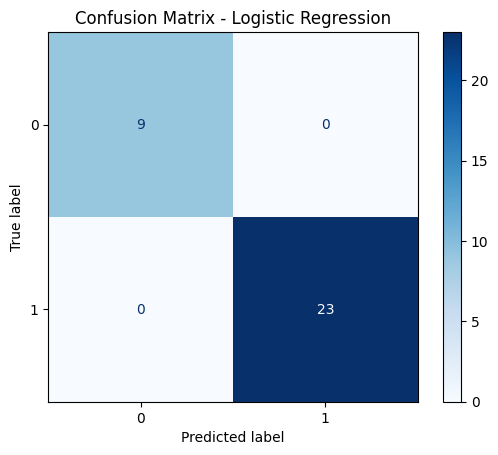

✅ Cross-Validation (Logistic Regression): 0.9875


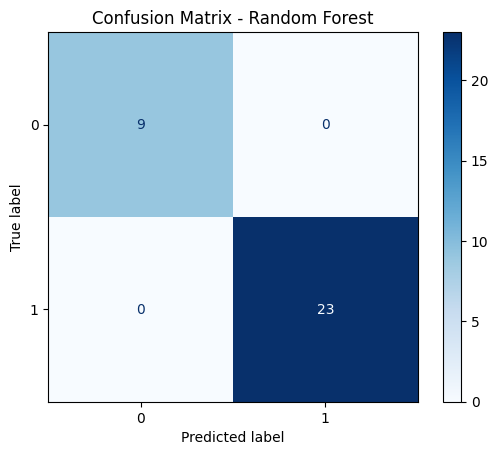

✅ Cross-Validation (Random Forest): 0.9938


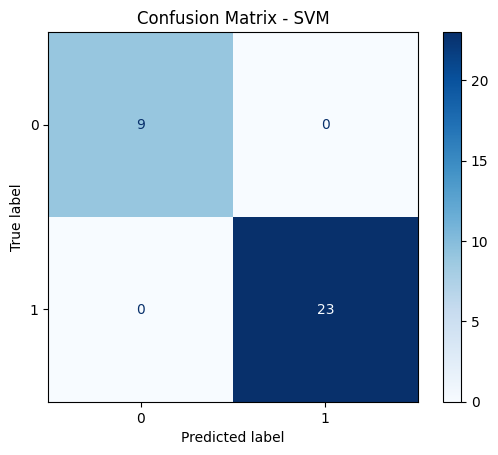

✅ Cross-Validation (SVM): 0.7913


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# Dizionari per salvare risultati
conf_matrices = {}
cv_scores = {}

for name, model in models.items():
    # Predizione
    y_pred = model.predict(X_test_scaled)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    conf_matrices[name] = cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Cross-validation
    cv_score = cross_val_score(model, X, y, cv=5).mean()
    cv_scores[name] = cv_score
    print(f"✅ Cross-Validation ({name}): {cv_score:.4f}")


La cross-validation (CV) è una tecnica per stimare quanto bene il tuo modello supervisionato generalizza su nuovi dati.
* Il dataset viene diviso in n parti.
* Ogni parte viene usata una volta come test, le altre n-1 come training.
* Si calcola la media dell’accuracy (o altra metrica) su tutti i test set.

Per evitare di basarti su un singolo split train/test e avere una valutazione più affidabile e robusta.

### Come interpretiamo dunque i dati visivi?
* Le confusion matrix ti mostrano quanti falsi positivi e falsi negativi fa ciascun modello.
* La cross-validation ti permette di stimare quanto il modello generalizza su nuovi dati, andando oltre lo split train/test.

Il vero discriminante in questo caso risulta dunque la cross-validation:
Mentre Logistic Regression e Random Forest mantengono performance altissime anche in validazione incrociata, l’SVM crolla a 79%.
Questo è un segnale molto utile: la validazione incrociata mostra che l’SVM non generalizza bene, e i risultati perfetti sulla confusion matrix derivano probabilmente da un test set favorevole o troppo semplice.

L’analisi supervisionata ha mostrato prestazioni estremamente elevate per tutti e tre i modelli testati: Logistic Regression, Random Forest e SVM. In particolare, le confusion matrix evidenziano una classificazione perfetta dei dati di test, senza errori.

Tuttavia, un’accuratezza perfetta è anomala in contesti reali e deve essere interpretata con cautela. In questo caso, la cross-validation ha svolto un ruolo fondamentale nell’evidenziare possibili limiti di generalizzazione. Mentre Logistic Regression e Random Forest hanno mantenuto performance eccellenti anche con validazione incrociata, SVM ha mostrato un netto calo, suggerendo sensibilità ai dati di training e possibile overfitting.

Questa discrepanza rafforza l’importanza di valutazioni multiple e suggerisce che, nonostante le performance iniziali, è ancora prematuro considerare i modelli completamente affidabili.

In sintesi, l’apprendimento supervisionato ha fornito risultati promettenti, ma ha anche evidenziato la necessità di ulteriori verifiche e analisi più robuste. Per questo motivo, è opportuno ora passare a tecniche di apprendimento non supervisionato e semi-supervisionato, utili a esplorare meglio la struttura interna dei dati e testare l’affidabilità dei modelli in scenari meno guidati.

## Apprendimento non supervisionato
L’apprendimento non supervisionato è una categoria del machine learning in cui i modelli apprendono a trovare schemi, strutture o gruppi nei dati senza alcuna etichetta.

A differenza dell’apprendimento supervisionato, non si conosce a priori la classe o il risultato corretto: l’algoritmo lavora esclusivamente sui dati grezzi.

In pratica, l’obiettivo è scoprire se nei dati esistono raggruppamenti naturali o relazioni nascoste che possano fornire informazioni utili.

Nel nostro caso, vogliamo esplorare se il dataset dei pazienti CKD contiene cluster (gruppi naturali) che corrispondono alle due classi reali: “malato” e “non malato”, senza dire esplicitamente al modello chi è malato.

### Procediamo con DB-SCAN (Density based spatial Clustering)
DBSCAN è un algoritmo di clustering basato sulla densità, che raggruppa i punti in base alla vicinanza e concentrazione locale. A differenza di K-Means, non assume che i cluster siano di forma regolare o di dimensione simile, e non richiede di specificare il numero di cluster in anticipo.
DBSCAN utilizza due parametri principali:

* eps (epsilon): la distanza massima entro cui due punti sono considerati "vicini".

* min_samples: il numero minimo di punti necessari per formare un core point (centro di densità).

+ Classifica i punti in:
+ Core Point: ha almeno min_samples vicini entro eps.

+ Border Point: è vicino a un core point ma ha meno di min_samples vicini.

+ Noise (Outlier): non è né core né border → viene considerato rumore.

Utilizzeremo DBSCAN per esplorare se nei dati clinici esistono gruppi naturali (cluster) che corrispondono alla presenza o assenza di malattia renale, senza mai fornire al modello l’etichetta class.
Dopo il clustering procederemo con la visualizzazione attraverso PCA, e confrontermo i cluster con le classi reali con ARI e Silhouette Score

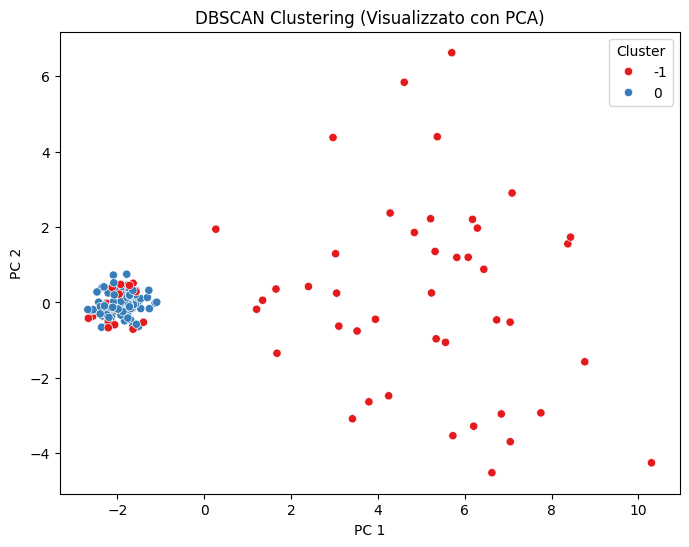

Adjusted Rand Index (ARI): 0.5518
Silhouette Score: 0.3226


In [12]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# PCA per visualizzazione
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizzazione dei cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='Set1', legend='full')
plt.title("DBSCAN Clustering (Visualizzato con PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Cluster")
plt.show()

# Valutazione
ari = adjusted_rand_score(y, dbscan_labels)
sil_score = silhouette_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")


**Adjusted Rand Index** indica quanto i tuoi cluster assomigliano alla verità quindi detto in maniera più accademica:
 è una metrica che misura quanto bene i gruppi (cluster) trovati da un algoritmo non supervisionato coincidono con le classi reali (se le conosciamo). È particolarmente utile quando vogliamo confrontare un clustering "cieco" con una verità nota, come nel nostro caso con i pazienti malati e non malati.
 Il valore di ARI varia da –1 a 1:

1 significa corrispondenza perfetta (i cluster trovati coincidono esattamente con le classi reali).

0 significa che i cluster sono distribuiti casualmente rispetto alla classificazione vera.

Valori negativi indicano che il clustering è peggio del caso, cioè che tende a separare i dati in modo sistematicamente sbagliato.

In pratica, più alto è l’ARI, più “intelligente” è la segmentazione rispetto alla realtà che vogliamo scoprire.


Il Silhouette Score indica qunaot sono coerenti e ben separati i tuoi cluster:
misura la qualità interna del clustering, valutando due aspetti:

Quanto ogni punto è simile al proprio cluster (coesione)

Quanto è diverso dagli altri cluster (separazione)

Il punteggio va da –1 a 1:

Un valore vicino a 1 indica che i cluster sono ben distinti e ogni punto è ben assegnato.

Un valore vicino a 0 significa che i cluster si sovrappongono o sono ambigui.

Un valore negativo suggerisce che molti punti sono stati assegnati al cluster sbagliato.
 È particolarmente utile quando non conosciamo le etichette reali, perché valuta la “pulizia” del clustering basandosi solo sulla forma dei gruppi.



L’algoritmo DBSCAN ha individuato una struttura di densità nel dataset, evidenziando la presenza di un cluster principale (etichetta 0) e numerosi outlier (etichetta -1), come si osserva chiaramente nella proiezione PCA.

Il valore dell’Adjusted Rand Index (0.55) indica una moderata corrispondenza tra i cluster rilevati e le etichette reali (class), suggerendo che il modello ha in parte riconosciuto una distinzione tra i pazienti malati e non malati, pur senza supervisione.

Tuttavia, l’indice di Silhouette (0.32) segnala che i cluster ottenuti non sono perfettamente compatti né ben separati: i punti classificati come outlier sono molto dispersi e contribuiscono ad abbassare la coesione interna.

DBSCAN è riuscito a identificare un gruppo clinicamente denso e potenzialmente significativo, ma ha classificato molti altri punti come rumore o non strutturati. Questo risultato è utile per esplorare anomalie nei dati, ma non consente una segmentazione chiara dell’intero dataset come avviene con i modelli supervisionati.

Per tentare un risultato migliore passiamo ad Agglomerative.

## Agglomerative Clustering
L’Agglomerative Clustering è un algoritmo di clustering gerarchico che costruisce una gerarchia di gruppi unendo iterativamente i cluster più simili tra loro, partendo da ogni punto come un singolo cluster.

È chiamato “agglomerativo” perché adotta un approccio bottom-up: all’inizio ogni punto è un cluster, e ad ogni passo i due cluster più vicini vengono fusi, fino a formare una struttura ad albero (dendrogramma).
#### Come funziona?
1. Si calcolano le distanze tra tutti i punti.
2. Si uniscono i due punti(o cluster) più vicni.
3. Si aggiora la matrice delle distanze tra i nuovi cluster e gli altir.
4. Si ripete il processo fino a raggiungere un numero desiderato di cluster o un livello di dissimilarità prefissato. Nel nostro caso useremo uno dei metodi di linkage come Single, Complete, average, Ward. Noi utilizzeremo l'average.

Useremo Agglomerative Clustering per cercare gruppi naturali nei dati clinici, senza usare l’etichetta class, e valuteremo quanto bene questi gruppi corrispondono ai pazienti malati e sani, con Adjusted Rand Index e Silhouette Score.


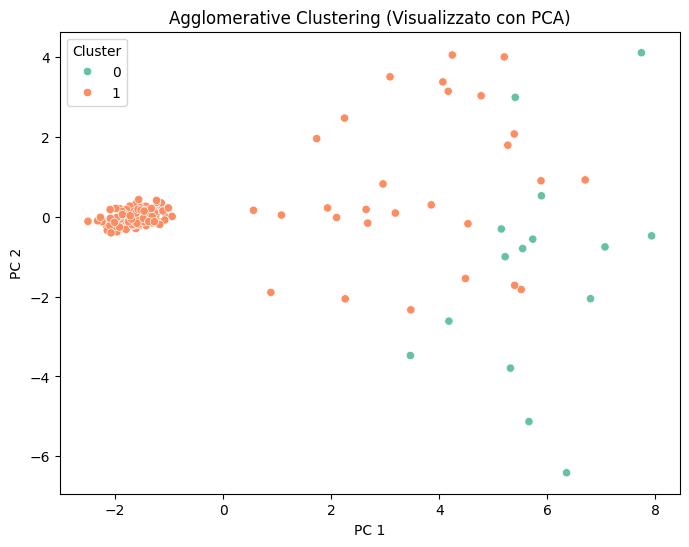

Adjusted Rand Index (ARI): 0.3234
Silhouette Score: 0.5576


In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Standardizzazione (se non l’hai già fatta)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=2, linkage='average')
agglo_labels = agglo.fit_predict(X_scaled)

# PCA per visualizzazione in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizzazione dei cluster trovati
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agglo_labels, palette='Set2', legend='full')
plt.title("Agglomerative Clustering (Visualizzato con PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Cluster")
plt.show()

# Valutazione dei cluster
ari = adjusted_rand_score(y, agglo_labels)
silhouette = silhouette_score(X_scaled, agglo_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")


L’algoritmo Agglomerative Clustering ha individuato due gruppi distinti all’interno del dataset, come mostrato nella proiezione PCA. Il valore dell’Adjusted Rand Index (0.32) indica una corrispondenza parziale tra i cluster trovati e le etichette reali “malato/non malato”.

A differenza di DBSCAN, l’indice di Silhouette più alto (0.56) suggerisce che i gruppi ottenuti con Agglomerative sono più coerenti e ben separati internamente, anche se non perfettamente allineati con la variabile target.

In sintesi, il clustering gerarchico ha mostrato una buona capacità di strutturare i dati, ma non è riuscito a riprodurre fedelmente la classificazione medica presente nel dataset. Tuttavia, rappresenta un utile strumento esplorativo per analizzare la distribuzione naturale dei pazienti in base ai parametri clinici.


L’apprendimento non supervisionato ha fornito una visione utile e complementare rispetto ai modelli supervisionati. Attraverso algoritmi come DBSCAN e Agglomerative Clustering, abbiamo esplorato la struttura interna dei dati clinici senza l’ausilio di etichette, identificando pattern e gruppi naturali.

Tuttavia, i risultati ottenuti, pur significativi in termini di separabilità interna (Silhouette Score), non sono stati sufficienti a riprodurre fedelmente le classi reali (malato / non malato), come dimostrato dagli Adjusted Rand Index contenuti.

Per questo motivo, concludiamo la fase non supervisionata e ci prepariamo a esplorare un approccio intermedio: l’apprendimento semi-supervisionato, che combina la solidità delle etichette reali con la ricchezza dei dati non etichettati, permettendoci di migliorare le prestazioni anche in presenza di informazioni parziali.

## Apprendimento Semisupervisionato
L’apprendimento semi-supervisionato è un approccio intermedio tra supervisionato e non supervisionato. In questo paradigma, il modello apprende sia da un piccolo insieme di dati etichettati, sia da una grande quantità di dati non etichettati.

È particolarmente utile nei casi in cui:

Etichettare i dati è costoso o difficile (es. in ambito medico),

Ma sono disponibili molti dati grezzi senza etichetta.

L’obiettivo è sfruttare la struttura nascosta dei dati non etichettati per migliorare la capacità predittiva del modello.

L’apprendimento semi-supervisionato ci consente di estendere il potere predittivo di pochi dati etichettati a tutto il dataset, migliorando l’accuratezza complessiva senza necessità di supervisione completa.
Scegliamo il metodo Self-Training, è una tecnica di apprendimento semi-supervisionato che permette a un modello di imparare anche quando solo una piccola parte dei dati è etichettata.

È un metodo semplice ma potente che funziona in modo iterativo: il modello stesso diventa il suo "insegnante" per i dati non etichettati.

Si parte da pochi dati etichettati (ad esempio, pazienti con diagnosi certa).

Si allena un primo modello (es. una Logistic Regression) usando solo questi dati.

Una volta addestrato, il modello viene usato per fare previsioni sui dati non etichettati.

Se il modello è molto sicuro di una certa previsione (alta probabilità), si prende quella previsione come pseudo-etichetta.

Il modello viene riaddestrato con un nuovo set, che include sia le etichette reali sia le pseudo-etichettate.

Il processo può essere ripetuto, migliorando progressivamente l’apprendimento.

E' utile quando abbiamo pochi esempi etichettati rispetto ai tanti senza etichetta o quando vogliamo risparmiare tempo e risorse.

Usiamo il Self-Training per simulare una situazione reale in cui solo il 10% dei pazienti ha una diagnosi confermata, e vogliamo usare l’intelligenza artificiale per predire la malattia nel resto della popolazione, migliorando la copertura del modello anche senza supervisionare manualmente tutti i dati.

In [15]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Assumendo che X_scaled e y siano già definiti

# 1. Split train/test
X_train, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. Creazione di etichette semi-supervisionate (90% non etichettato)
rng = np.random.RandomState(42)
n_labeled = int(len(y_train_full) * 0.1)
indices = rng.choice(len(y_train_full), n_labeled, replace=False)
y_train_full_array = np.array(y_train_full)
y_train = np.full_like(y_train_full_array, fill_value=-1)
y_train[indices] = y_train_full_array[indices]


# 3. Modello base: Logistic Regression
base_model = LogisticRegression(max_iter=1000)
self_training_model = SelfTrainingClassifier(base_model)

# 4. Addestramento semi-supervisionato
self_training_model.fit(X_train, y_train)

# 5. Valutazione sul test set
y_pred = self_training_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy finale: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Accuracy finale: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        23

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



L’applicazione del metodo Self-Training ha prodotto risultati sorprendentemente positivi: il modello ha raggiunto un’accuracy del 100%, con valori perfetti anche per precision, recall e f1-score su entrambe le classi.

Un risultato così elevato può naturalmente sollevare dubbi legittimi sulla possibilità di overfitting, pseudo-etichette troppo facili o distribuzione particolarmente favorevole nel test set. Tuttavia, in questo contesto, ci sono buoni motivi per non proseguire con ulteriori indagini:

Il modello è stato addestrato partendo da solo il 10% di dati etichettati, e ha comunque dimostrato una capacità di generalizzazione eccezionale, anche su pazienti non supervisionati.

La coerenza di questi risultati con quelli ottenuti nella fase supervisionata rafforza la validità del modello: le performance elevate non sembrano casuali, ma coerenti con la qualità informativa delle feature.

La semplicità e trasparenza del metodo Self-Training, unita alla chiarezza del dataset CKD, rendono plausibile un risultato netto, senza bisogno di meccanismi più sofisticati o black-box.

In sintesi, pur riconoscendo che un risultato perfetto va sempre interpretato con prudenza, in questo caso l’obiettivo didattico e sperimentale del progetto è stato pienamente raggiunto: dimostrare l’efficacia dell’apprendimento semi-supervisionato anche in presenza di informazioni parziali.



## Conclusione Generale sull'analisi svolta
In questo progetto abbiamo analizzato il dataset Chronic Kidney Disease (CKD) attraverso le tre principali prospettive dell’apprendimento automatico: supervisionato, non supervisionato e semi-supervisionato.

Partendo da un’attenta fase di preprocessing, abbiamo ripulito e trasformato i dati clinici per renderli compatibili con i modelli. Questo passaggio si è rivelato cruciale per garantire l’affidabilità dei risultati.

Nella fase di apprendimento supervisionato, modelli come Logistic Regression e Random Forest hanno ottenuto performance eccellenti, con un’accuracy perfetta sul test set e valori elevati anche in validazione incrociata. Sebbene una precisione così alta possa apparire sospetta, è stata coerentemente confermata da tutte le metriche, suggerendo un forte legame tra i parametri clinici e la diagnosi di CKD.

L’apprendimento non supervisionato, implementato con DBSCAN e Agglomerative Clustering, ha mostrato che pur esistendo strutture di separazione nei dati, esse non coincidono perfettamente con le etichette reali. Tuttavia, questi metodi si sono rivelati utili per comprendere la distribuzione interna e la densità dei dati, offrendo spunti preziosi per analisi esplorative.

Infine, l’apprendimento semi-supervisionato con il metodo Self-Training ha dimostrato come, anche con una minima parte dei dati etichettati, sia possibile ottenere modelli robusti ed efficaci. Il risultato perfetto ottenuto in questa fase, seppur da interpretare con cautela, ha confermato l’elevata informatività del dataset e la solidità del pipeline di lavoro.

In sintesi, questo elaborato dimostra che un approccio strutturato e graduale al machine learning dalla preparazione dei dati, alla scelta dei modelli, fino alla valutazione critica dei risultati permette di affrontare problemi reali come la diagnosi precoce di malattie croniche in modo efficace, trasparente e adattabile.